https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb

In [116]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 

#for loading and visualizing audio files
import librosa
import librosa.display

#to play audio
import IPython.display as ipd

from scipy.io import wavfile
import numpy as np
from scipy import signal
import scipy.signal as sps
from scipy.signal import butter, lfilter

In [117]:
noisyspeech_fpath = "audio/noisy_speech/SNR_-3dB/"
noisyspeech_clips = os.path.join(noisyspeech_fpath)

In [118]:
speech_fpath = "audio/test_speech/"
speech_clips = os.path.join(speech_fpath)

In [119]:
POS = os.path.join(speech_fpath)
NEG = os.path.join(noisyspeech_fpath)

In [120]:
pos = tf.data.Dataset.list_files(POS+'*.wav')
neg = tf.data.Dataset.list_files(NEG+'*.wav')

In [121]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [122]:
lengths = []
for file in os.listdir(os.path.join(noisyspeech_fpath)):
    tensor_wave = os.path.join(noisyspeech_fpath, file)
    lengths.append(len(tensor_wave))

In [123]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [124]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [125]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=43>

In [126]:
def preprocess(file_path, label): 
    file_contents = tf.io.read_file(file_path)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    wav = wav[:16000]
    zero_padding = tf.zeros([16000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [127]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
print(filepath)
print(label)

b'audio\\test_speech\\speech_30.wav'
1.0


In [128]:
spectrogram, label = preprocess(filepath, label)

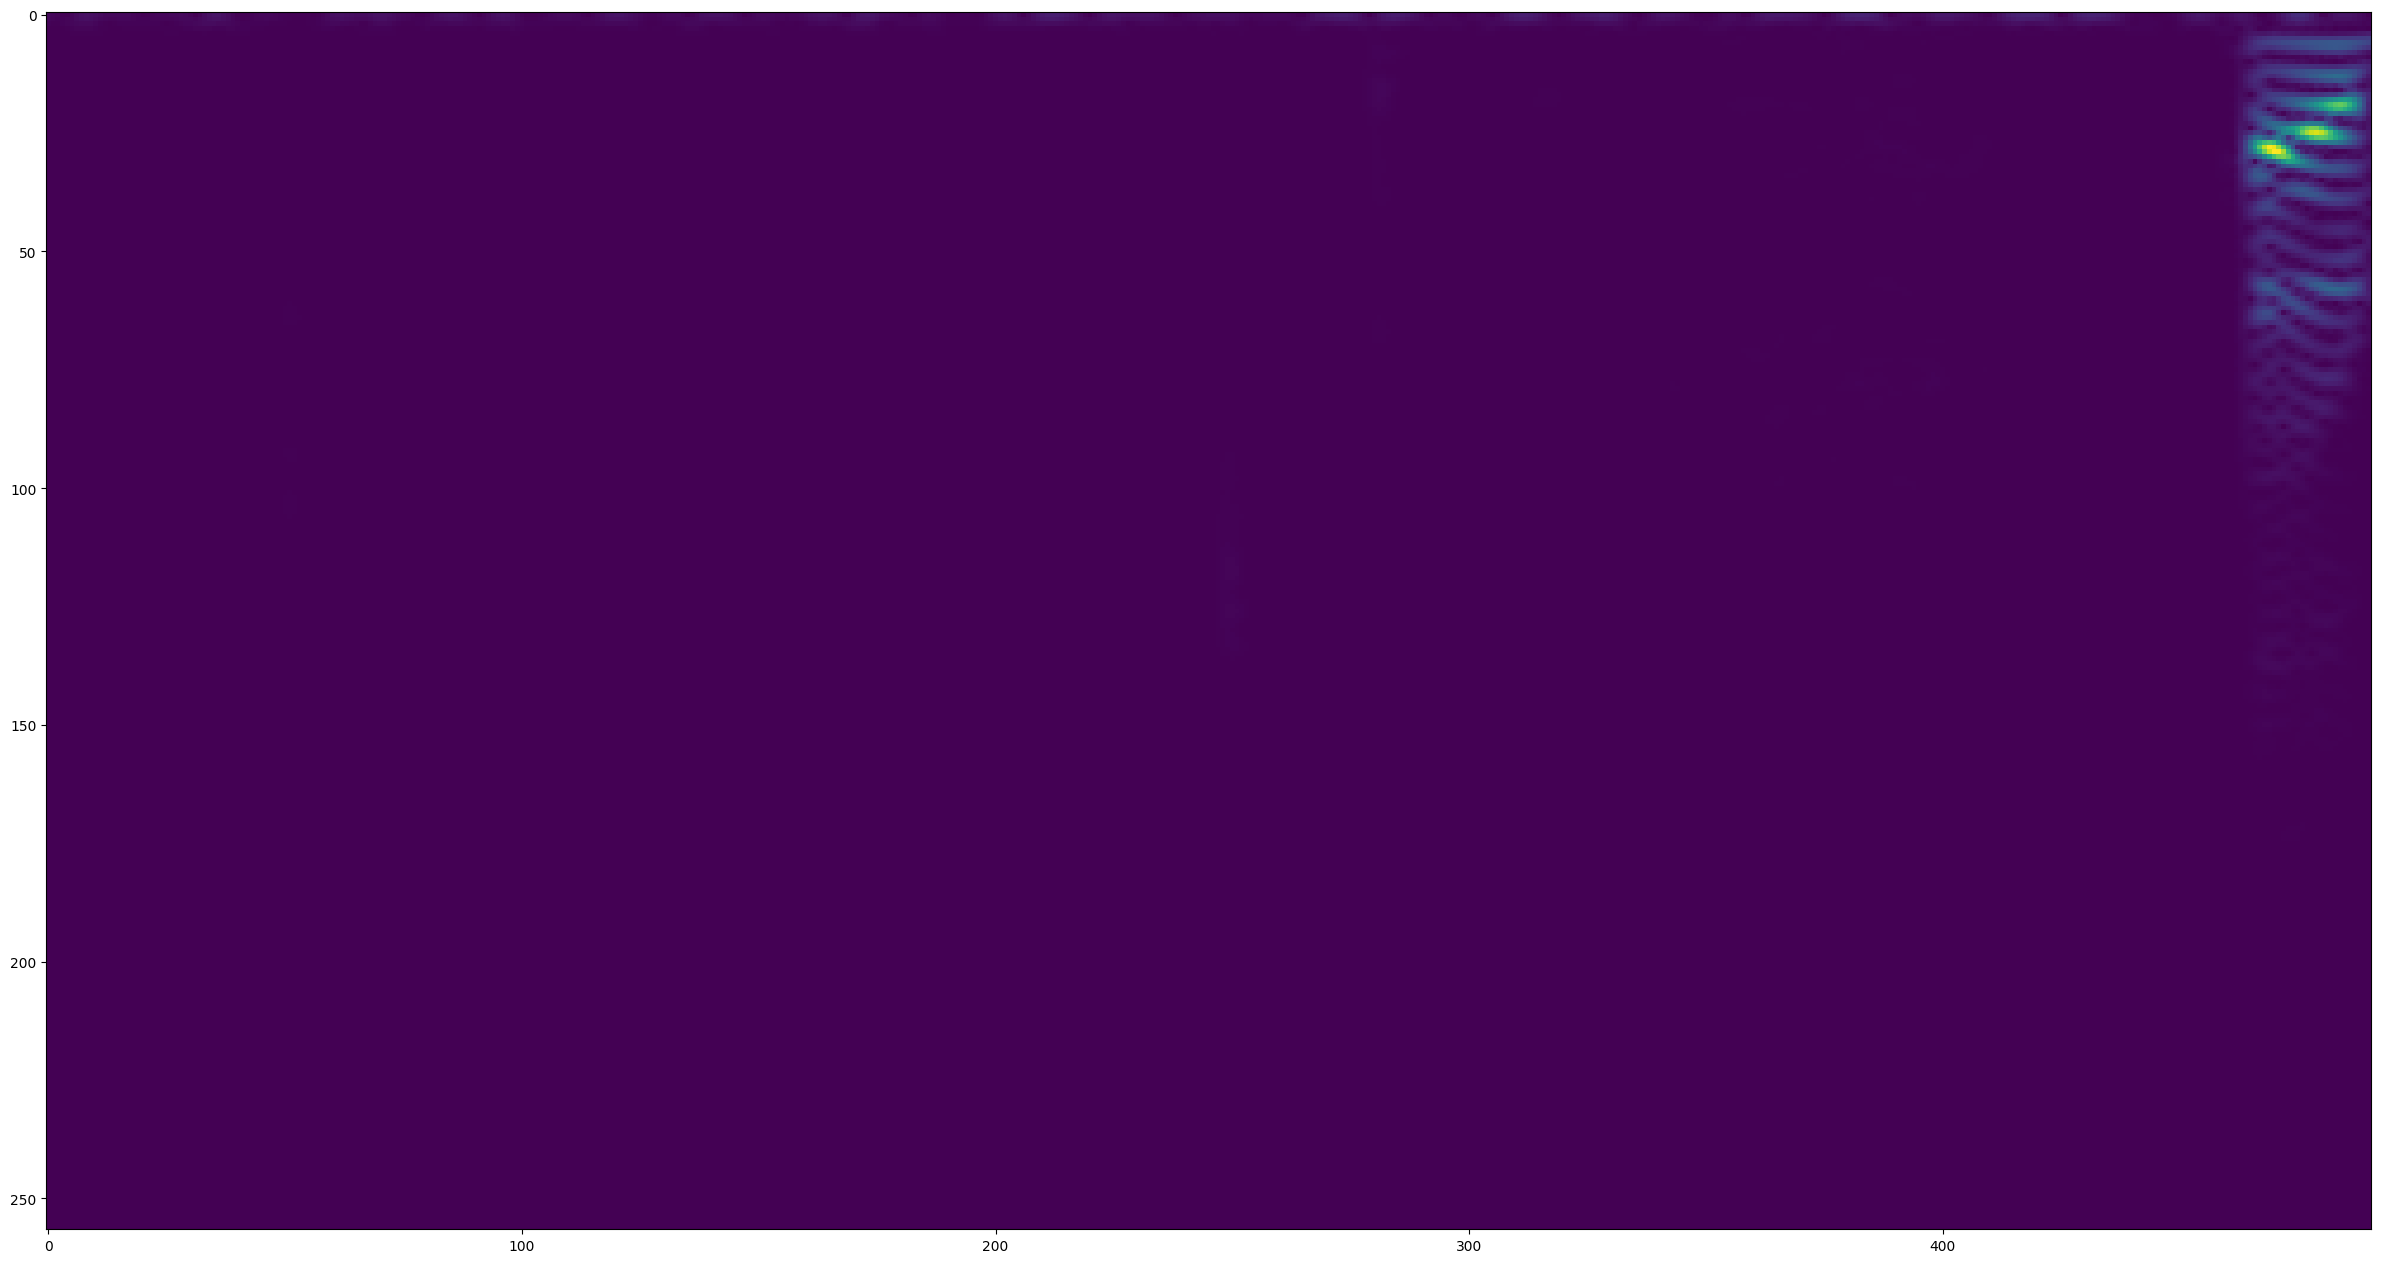

In [129]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [130]:
print(data)
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [131]:
train = data.take(36)
test = data.skip(36).take(15)
print(train)
print(data)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


In [132]:
samples, labels = train.as_numpy_iterator().next()

In [133]:
samples.shape

(16, 491, 257, 1)

In [134]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten

In [148]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [149]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [150]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 489, 255, 16)      160       
                                                                 
 conv2d_19 (Conv2D)          (None, 487, 253, 16)      2320      
                                                                 
 flatten_9 (Flatten)         (None, 1971376)           0         
                                                                 
 dense_11 (Dense)            (None, 128)               252336256 
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 252,338,865
Trainable params: 252,338,865
Non-trainable params: 0
_________________________________________________________________


In [151]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


: 

: 